In [1]:
import src.utils as ut
from src.config import Config
from src.data import load_dataset_and_make_dataloaders
from src.sigma import build_sigma_schedule
from src.common import euler_sample
from pathlib import Path
from io import BytesIO
import torch
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import zipfile
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
wd = Path("/storage/homefs/mc21s017/miniproject1_diffusion/runs/20251210_155344_fm_cond")

_, info = load_dataset_and_make_dataloaders(dataset_name="FashionMNIST", root_dir="../data", batch_size=32)
chkp = ut.find_latest_checkpoint(wd / "checkpoints")
model = ut.build_model_for_sampling(wd / "config.yaml", device, info)
model = ut.load_ckpt_into_model(model, chkp, device)

cfg_drop_prob is set but cf_guidance is False. cfg_drop_prob will be ignored.


In [3]:
# Load config and validation dataloader
cfg = Config.load_from_yaml(Path("/storage/homefs/mc21s017/miniproject1_diffusion/runs/20251210_155344_fm_cond/config.yaml"))
dataloaders, info = load_dataset_and_make_dataloaders(
        dataset_name=cfg.data.dataset_name,
        root_dir=str(cfg.data.data_root),
        batch_size=cfg.data.batch_size,
        num_workers=cfg.data.num_workers,
        pin_memory=cfg.data.pin_memory,
    )
valid_loader = dataloaders.valid

cfg_drop_prob is set but cf_guidance is False. cfg_drop_prob will be ignored.


In [4]:
# Create the stats for the real validation data
ut.save_fid_real_stats(
        valid_loader,
        cfg.data.dataset_name,
        device="cuda",
        n=len(valid_loader.dataset),
    )

In [9]:
# Generate the samples for the loaded model
channels = info.image_channels
H = info.image_size
sigma_data = float(info.sigma_data)
n_images = len(valid_loader.dataset)

nfe_list = [2 << (b - 1) for b in range(3, 11)]  # NFE = number of steps (function evaluations)
print(nfe_list)

for nfe in nfe_list:
    # Generate samples
    sigmas = build_sigma_schedule(nfe)
    sigmas = sigmas.to(device)

    zip_path = Path("fid_samples") / f"nfe_{nfe}.zip"
    zip_path.parent.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(
        zip_path, "w", compression=zipfile.ZIP_DEFLATED
    ) as zf:
        produced = 0
        while produced < n_images:
            b = min(cfg.data.batch_size, n_images - produced)
            # unconditioned generation
            xgen = euler_sample(
                model,
                sigmas,
                b,
                info.image_channels,
                info.image_size,
                sigma_data,
                device,
            )
            imgs = ut.to_unit_range(xgen)

            for i in range(imgs.size(0)):
                buf = BytesIO()
                save_image(imgs[i], buf, format="PNG")
                buf.seek(0)
                zf.writestr(f"sample_{produced:05d}.png", buf.read())
                produced += 1

compute FID of a folder with fashionmnist statistics
Found 10000 images in the folder fid_samples/nfe_8.zip


FID nfe_8.zip : 100%|██████████| 313/313 [00:22<00:00, 14.03it/s]


NFE=8, FID=36.22


In [23]:
# FID lists
fid_uncond = []
fid_cond = []
fid_cond_unet = []

# NFE values (same as your generation loop)
nfe_list = [2 << (b - 1) for b in range(3, 11)] # [8,16,32,64,128,256,512,1024]

for nfe in nfe_list:
    # unconditioned zip
    zip_uncond = Path("fid_samples") / f"nfe_un_{nfe}.zip"
    # conditioned zip
    zip_cond = Path("fid_samples") / f"nfe_{nfe}.zip"
    # conditioned unet zip
    zip_cond_unet = Path("fid_samples") / f"nfe_unet_{nfe}.zip"

    # Compute FID using your utility
    fid_u = ut.compute_fid(str(zip_uncond), cfg.data.dataset_name, device="cuda")
    fid_c = ut.compute_fid(str(zip_cond), cfg.data.dataset_name, device="cuda")
    fid_c_u = ut.compute_fid(str(zip_cond_unet), cfg.data.dataset_name, device="cuda")

    fid_uncond.append(fid_u)
    fid_cond.append(fid_c)
    fid_cond_unet.append(fid_c_u)

    print(f"NFE {nfe}:   FID uncond={fid_u:.2f} | cond={fid_c:.2f} | cond unet = {fid_c_u:.2f}")


compute FID of a folder with fashionmnist statistics
Found 10000 images in the folder fid_samples/nfe_unet_8.zip


FID nfe_unet_8.zip : 100%|██████████| 313/313 [00:14<00:00, 21.25it/s]


NFE 8:   FID uncond=42.11 | cond=36.22 | cond unet = 24.64
compute FID of a folder with fashionmnist statistics
Found 10000 images in the folder fid_samples/nfe_unet_16.zip


FID nfe_unet_16.zip : 100%|██████████| 313/313 [00:13<00:00, 22.79it/s]


NFE 16:   FID uncond=23.11 | cond=18.71 | cond unet = 11.59
compute FID of a folder with fashionmnist statistics
Found 10000 images in the folder fid_samples/nfe_unet_32.zip


FID nfe_unet_32.zip : 100%|██████████| 313/313 [00:13<00:00, 22.64it/s]


NFE 32:   FID uncond=19.52 | cond=13.35 | cond unet = 9.17
compute FID of a folder with fashionmnist statistics
Found 10000 images in the folder fid_samples/nfe_unet_64.zip


FID nfe_unet_64.zip : 100%|██████████| 313/313 [00:14<00:00, 21.00it/s]


NFE 64:   FID uncond=18.88 | cond=11.99 | cond unet = 8.43
compute FID of a folder with fashionmnist statistics
Found 10000 images in the folder fid_samples/nfe_unet_128.zip


FID nfe_unet_128.zip : 100%|██████████| 313/313 [00:14<00:00, 21.61it/s]


NFE 128:   FID uncond=19.38 | cond=11.35 | cond unet = 8.21
compute FID of a folder with fashionmnist statistics
Found 10000 images in the folder fid_samples/nfe_unet_256.zip


FID nfe_unet_256.zip : 100%|██████████| 313/313 [00:13<00:00, 22.80it/s]


NFE 256:   FID uncond=19.00 | cond=11.27 | cond unet = 7.93
compute FID of a folder with fashionmnist statistics
Found 10000 images in the folder fid_samples/nfe_un_512.zip


FID nfe_un_512.zip : 100%|██████████| 313/313 [00:13<00:00, 22.50it/s]


compute FID of a folder with fashionmnist statistics
Found 10000 images in the folder fid_samples/nfe_512.zip


FID nfe_512.zip : 100%|██████████| 313/313 [00:14<00:00, 21.91it/s]


compute FID of a folder with fashionmnist statistics
Found 10000 images in the folder fid_samples/nfe_unet_512.zip


FID nfe_unet_512.zip : 100%|██████████| 313/313 [00:14<00:00, 22.04it/s]


NFE 512:   FID uncond=19.56 | cond=11.16 | cond unet = 8.19
compute FID of a folder with fashionmnist statistics
Found 3136 images in the folder fid_samples/nfe_un_1024.zip


FID nfe_un_1024.zip : 100%|██████████| 98/98 [00:08<00:00, 11.21it/s]


compute FID of a folder with fashionmnist statistics
Found 10000 images in the folder fid_samples/nfe_1024.zip


FID nfe_1024.zip : 100%|██████████| 313/313 [00:14<00:00, 22.35it/s]


compute FID of a folder with fashionmnist statistics
Found 7104 images in the folder fid_samples/nfe_unet_1024.zip


FID nfe_unet_1024.zip : 100%|██████████| 222/222 [00:12<00:00, 17.99it/s]


NFE 1024:   FID uncond=22.56 | cond=11.10 | cond unet = 8.83


In [24]:
# FID lists (pre-computed)
fid_uncond = [42.11,23.11,19.52,18.88,19.38,19.00,19.56,22.56]
fid_cond = [36.22, 18.71,13.35,11.99,11.35,11.27,11.16,11.10]
fid_cond_unet = [24.64,11.59,9.17,8.43,8.21,7.93,8.19,8.83]

In [26]:
# -------------------
# Find best FID points
# -------------------
nfe_arr = np.array(nfe_list)
fid_uncond_arr = np.array(fid_uncond)
fid_cond_arr   = np.array(fid_cond)
fid_cond_unet_arr = np.array(fid_cond_unet)

best_idx_uncond = np.argmin(fid_uncond_arr)
best_idx_cond   = np.argmin(fid_cond_arr)
best_idx_cond_unet = np.argmin(fid_cond_unet_arr)

best_nfe_uncond = nfe_arr[best_idx_uncond]
best_fid_uncond = fid_uncond_arr[best_idx_uncond]

best_nfe_cond = nfe_arr[best_idx_cond]
best_fid_cond = fid_cond_arr[best_idx_cond]

best_nfe_cond_unet = nfe_arr[best_idx_cond_unet]
best_fid_cond_unet = fid_cond_unet_arr[best_idx_cond_unet]

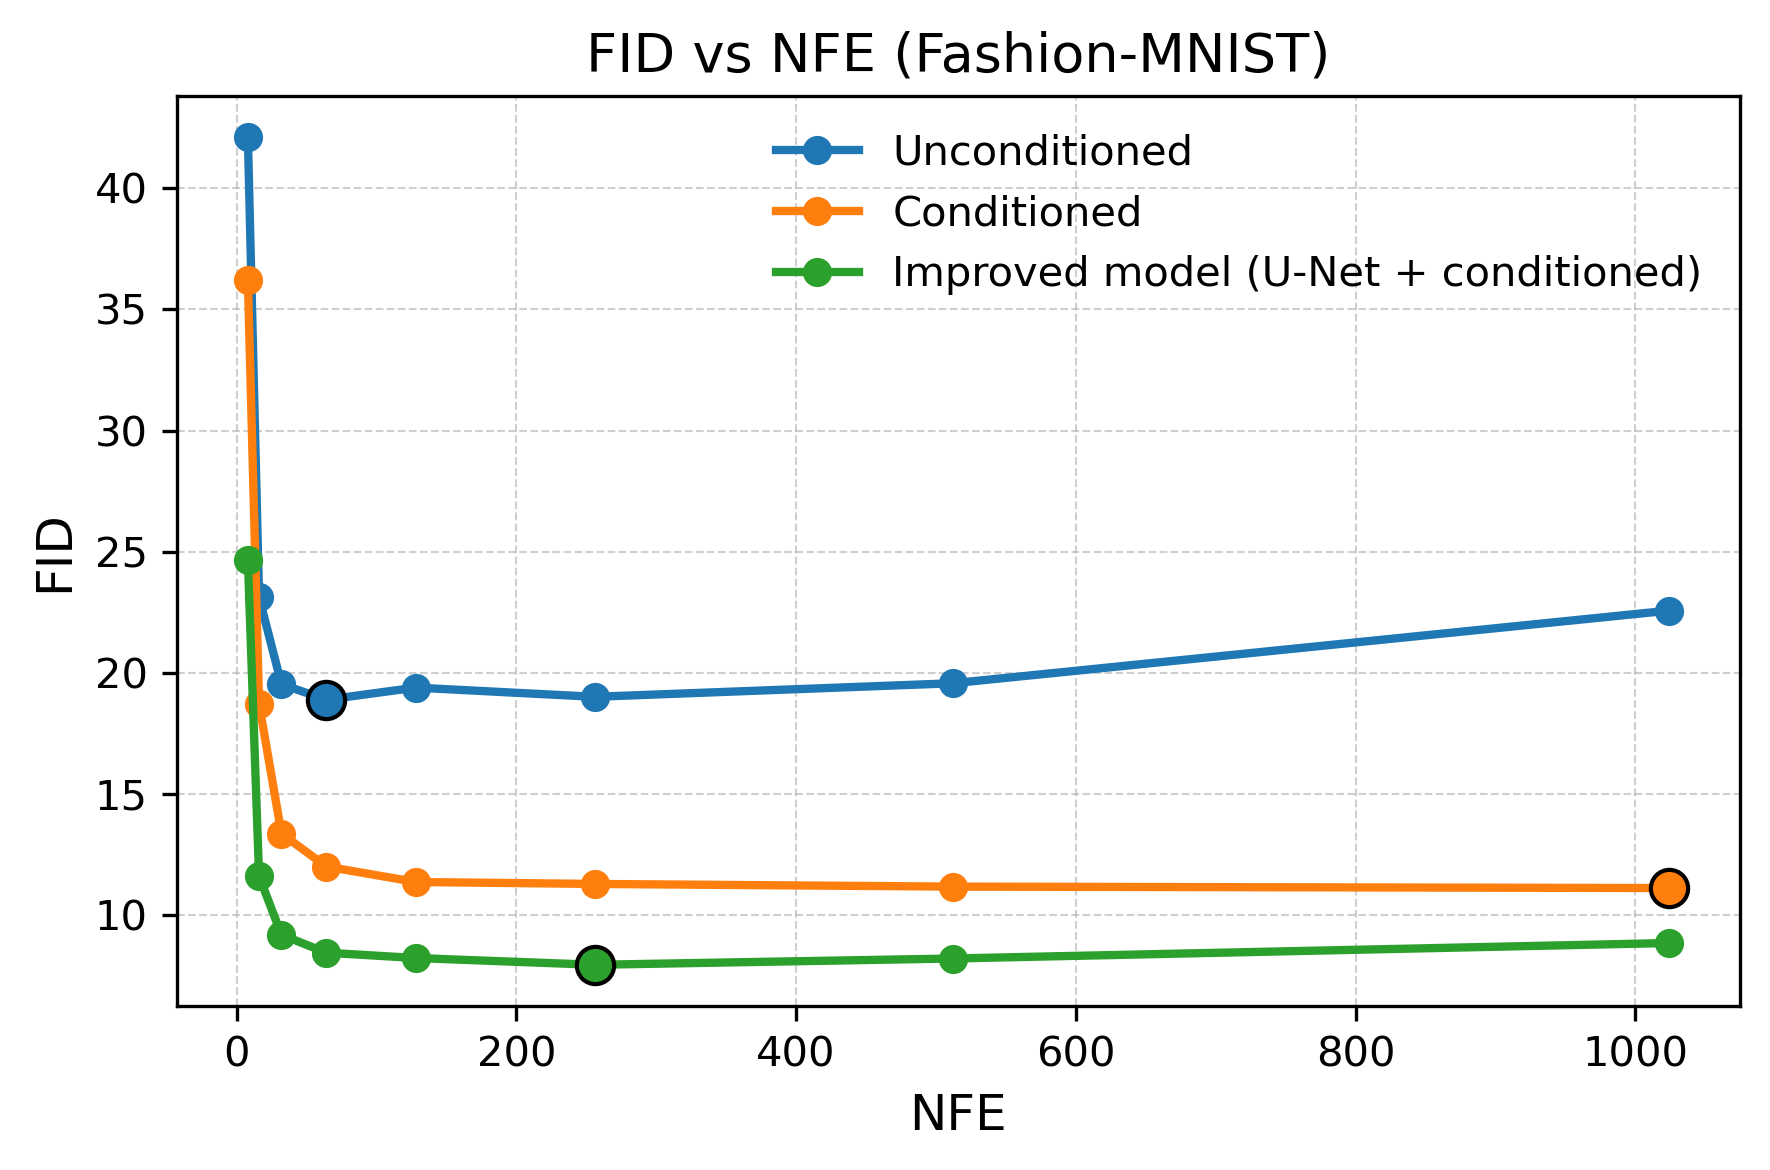

In [29]:
# -------------------
# --- Plot ---
# -------------------
plt.figure(figsize=(6,4), dpi=300)

plt.plot(nfe_list, fid_uncond, marker="o", linewidth=2, markersize=6, label="Unconditioned")
plt.plot(nfe_list, fid_cond, marker="o", linewidth=2, markersize=6, label="Conditioned")
plt.plot(nfe_list, fid_cond_unet, marker="o", linewidth=2, markersize=6, label="Improved model (U-Net + conditioned)")

plt.scatter(best_nfe_uncond, best_fid_uncond,s=80, marker="o", edgecolors="black", zorder=3)
plt.scatter(best_nfe_cond, best_fid_cond,s=80, marker="o", edgecolors="black", zorder=3)
plt.scatter(best_nfe_cond_unet, best_fid_cond_unet,s=80, marker="o", edgecolors="black", zorder=3)

plt.xlabel("NFE", fontsize=12)
plt.ylabel("FID", fontsize=12)
plt.title("FID vs NFE (Fashion-MNIST)", fontsize=13)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend(fontsize=10, frameon=False)

plt.tight_layout()
plt.show()


In [ ]:
# Create sampled images for a given model
channels = info.image_channels
H = info.image_size
sigma_data = float(info.sigma_data)
n_images = 10

sigmas = build_sigma_schedule(1024)
sigmas = sigmas.to(device)

samples = euler_sample(model, sigmas, n_images, channels, H, sigma_data, device, None)
imgs = samples.clamp(-1, 1).add(1).div(2)
grid_img = make_grid(imgs, nrow=min(10, n_images)).cpu()

plt.figure(figsize=(7, 5), dpi=150)
plt.imshow(grid_img.permute(1, 2, 0))
_ = plt.axis("off")